In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import os

import random
from IPython import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import ops
from tensorflow.keras import layers


2024-11-22 08:28:54.257210: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 08:29:00.696231: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732276743.028275    4041 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732276744.031558    4041 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 08:29:07.005077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

import tensorflow as tf


import matplotlib.pyplot as plt
import numpy as np

import os

In [3]:
# Data Preparation Utilities

def get_dataset_slice_paths(image_dir):
  '''returns a list of paths to the image files'''
  image_file_list = os.listdir(image_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]

  return image_paths


def map_image(image_filename):
  '''preprocesses the images'''
  img_raw = tf.io.read_file(image_filename)
  image = tf.image.decode_jpeg(img_raw)

  image = tf.cast(image, dtype=tf.float32)
  image = tf.image.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
  image = image / 255.0
   
  image = tf.reshape(image, shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1,))
  print(image.shape) 
  return image

# Function to visualize a batch of images
def visualize_batch(dataset, num_images=5):
    # Take one batch from the dataset
    for batch in dataset.take(1):
        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            # Get the i-th image from the batch
            image = batch[i]
            
            # Display the image
            plt.subplot(1, num_images, i + 1)
            plt.imshow(tf.squeeze(image), cmap='gray')
            plt.axis('off')
            plt.title(f'Image {i + 1}')
        plt.show()


In [4]:
# parameters for building the model and training
BATCH_SIZE=32
IMAGE_HEIGHT=128
IMAGE_WIDTH = 512     

In [5]:
# get the list containing the image paths
paths = get_dataset_slice_paths("dataset/train/good")

# shuffle the paths
random.shuffle(paths)

# split the paths list into to training (80%) and validation sets(20%).
paths_len = len(paths)
train_paths_len = int(paths_len * 0.8)

train_paths = paths[:train_paths_len]
val_paths = paths[train_paths_len:]

# load the training image paths into tensors, create batches and shuffle
training_dataset = tf.data.Dataset.from_tensor_slices((train_paths))
training_dataset = training_dataset.map(map_image)

training_dataset = training_dataset.shuffle(1000).batch(BATCH_SIZE)

# load the validation image paths into tensors and create batches
validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths))
validation_dataset = validation_dataset.map(map_image)
validation_dataset = validation_dataset.batch(BATCH_SIZE)


print(f'number of batches in the training set: {len(training_dataset)}')
print(f'number of batches in the validation set: {len(validation_dataset)}')

(128, 512, 1)
(128, 512, 1)
number of batches in the training set: 268
number of batches in the validation set: 67


I0000 00:00:1732276789.123485    4041 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9903 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:01:00.0, compute capability: 8.6


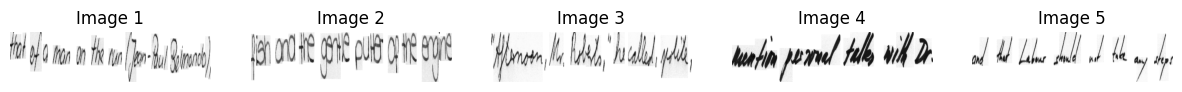

2024-11-22 08:29:52.682958: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
visualize_batch(training_dataset, num_images=5)

In [7]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
     # Encoder
    self.encoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),
        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=2, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=2, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=2, activation='relu', padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(latent_dim + latent_dim)  # For mean and log variance
    ])
    
    # Decoder
    self.decoder = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
        tf.keras.layers.Dense(units=8 * 32 * 512, activation='relu'),  # Reshape to match last conv output
        tf.keras.layers.Reshape(target_shape=(8, 32, 512)),
        tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same')  # No activation for output
    ])


  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [8]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  #cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  #logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  #logpz = log_normal_pdf(z, 0., 0.)
  #logqz_x = log_normal_pdf(z, mean, logvar)
  #return -tf.reduce_mean(logpx_z + logpz - logqz_x)
   # Reconstruction loss: Mean Squared Error between the input and the reconstruction
  # Reconstruction loss: Mean Squared Error between the input and the reconstruction
  reconstruction_loss_fn = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)  # No reduction initially
  # Sum over spatial dimensions (height and width) and then reduce mean across batch
  reconstruction_loss = tf.reduce_mean(
      tf.reduce_sum(
          reconstruction_loss_fn(x, x_logit), axis=[1, 2]  # Sum across height and width dimensions
      )
  )
  
  # KL divergence loss: regularizes the latent space (mean, logvar)
  kl_loss = -0.5 * tf.reduce_mean(
      tf.reduce_sum(
          1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1  # Sum over the latent space dimension
      )
  )
  
  # Total loss: sum of reconstruction loss and KL divergence
  total_loss = reconstruction_loss + kl_loss
  return total_loss, reconstruction_loss, kl_loss

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  #total_loss, reconstruction_loss, kl_loss = None
  with tf.GradientTape() as tape:
    total_loss, reconstruction_loss, kl_loss = compute_loss(model, x)

  # Get gradients and apply them using the optimizer
  gradients = tape.gradient(total_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return total_loss, reconstruction_loss, kl_loss


In [12]:
epochs = 60
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 64
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [13]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [14]:
batch_size=BATCH_SIZE
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in validation_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

In [16]:
import time
#generate_and_save_images(model, 0, test_sample)
training_losses = []
validation_losses =[]
for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in training_dataset:
    train_loss,_,_ = train_step(model, train_x, optimizer)
  end_time = time.time()

  
  for test_x in validation_dataset:
    validation_loss,_,_ = compute_loss(model, test_x)
  #elbo = -loss.result()
  #display.clear_output(wait=False)
  print('Epoch: {}, Training loss: {}, Validation loss: {} time elapse for current epoch: {}'
        .format(epoch, train_loss,validation_loss,end_time - start_time))
  #generate_and_save_images(model, epoch, test_sample)
  training_losses.append(train_loss)
  validation_losses.append(validation_loss)

2024-11-22 08:31:42.024184: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 1, Training loss: 2344.466796875, Validation loss: 2111.5654296875 time elapse for current epoch: 35.13797092437744
Epoch: 2, Training loss: 1234.54736328125, Validation loss: 2130.3095703125 time elapse for current epoch: 33.592496156692505


2024-11-22 08:32:57.245605: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 3, Training loss: 1838.0823974609375, Validation loss: 2129.67041015625 time elapse for current epoch: 34.09826135635376
Epoch: 4, Training loss: 1620.250244140625, Validation loss: 2060.284912109375 time elapse for current epoch: 33.8868465423584
Epoch: 5, Training loss: 1121.8533935546875, Validation loss: 1917.841552734375 time elapse for current epoch: 34.01959943771362
Epoch: 6, Training loss: 1578.6221923828125, Validation loss: 1889.627197265625 time elapse for current epoch: 34.40533638000488


2024-11-22 08:35:26.704575: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 7, Training loss: 2124.749267578125, Validation loss: 1882.846435546875 time elapse for current epoch: 34.58852958679199
Epoch: 8, Training loss: 1788.522705078125, Validation loss: 1872.1279296875 time elapse for current epoch: 34.63863229751587
Epoch: 9, Training loss: 1358.5631103515625, Validation loss: 1982.5865478515625 time elapse for current epoch: 34.4494743347168
Epoch: 10, Training loss: 1908.850341796875, Validation loss: 1847.5289306640625 time elapse for current epoch: 34.44381523132324
Epoch: 11, Training loss: 1392.151123046875, Validation loss: 1802.0106201171875 time elapse for current epoch: 34.34762191772461
Epoch: 12, Training loss: 1488.7095947265625, Validation loss: 1820.839111328125 time elapse for current epoch: 34.452118158340454
Epoch: 13, Training loss: 1324.439453125, Validation loss: 1771.739501953125 time elapse for current epoch: 34.92662286758423
Epoch: 14, Training loss: 1756.4306640625, Validation loss: 1828.3760986328125 time elapse for curre

2024-11-22 08:40:28.340105: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 15, Training loss: 3280.087890625, Validation loss: 1757.6070556640625 time elapse for current epoch: 34.4050509929657
Epoch: 16, Training loss: 1058.2081298828125, Validation loss: 1737.511474609375 time elapse for current epoch: 34.37803411483765
Epoch: 17, Training loss: 1622.7506103515625, Validation loss: 1709.497802734375 time elapse for current epoch: 34.570812940597534
Epoch: 18, Training loss: 1340.14697265625, Validation loss: 1700.990478515625 time elapse for current epoch: 34.37240028381348
Epoch: 19, Training loss: 1246.473876953125, Validation loss: 1693.889892578125 time elapse for current epoch: 34.43352723121643
Epoch: 20, Training loss: 2165.125732421875, Validation loss: 1686.7919921875 time elapse for current epoch: 34.45435619354248
Epoch: 21, Training loss: 1100.1103515625, Validation loss: 1671.9520263671875 time elapse for current epoch: 34.433202028274536
Epoch: 22, Training loss: 1444.5, Validation loss: 1667.9354248046875 time elapse for current epoch:

2024-11-22 08:50:30.880081: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch: 31, Training loss: 911.1616821289062, Validation loss: 1650.740234375 time elapse for current epoch: 34.466665506362915
Epoch: 32, Training loss: 1484.65966796875, Validation loss: 1639.237060546875 time elapse for current epoch: 34.965436697006226
Epoch: 33, Training loss: 1019.2398071289062, Validation loss: 1643.3533935546875 time elapse for current epoch: 34.7508282661438
Epoch: 34, Training loss: 961.9960327148438, Validation loss: 1641.03955078125 time elapse for current epoch: 34.631606101989746
Epoch: 35, Training loss: 1599.875244140625, Validation loss: 1650.7611083984375 time elapse for current epoch: 34.81648373603821
Epoch: 36, Training loss: 1339.4249267578125, Validation loss: 1687.2667236328125 time elapse for current epoch: 34.68208932876587
Epoch: 37, Training loss: 1034.764892578125, Validation loss: 1688.828369140625 time elapse for current epoch: 34.529677867889404
Epoch: 38, Training loss: 1515.55908203125, Validation loss: 1695.5533447265625 time elapse fo

In [17]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2


def preprocess_cheque_images(image_path, target_size=(512, 128)):
    color_image = cv2.imread(image_path)

    # Step 1: Convert RGB image to grayscale using the luminance formula
    gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

    # Step 2: Reshape the grayscale image to a 1D array of pixel intensities
    pixel_values = gray_image.reshape((-1, 1))

    # Step 3: Apply k-means clustering with k=2 for binarisation
    kmeans = KMeans(n_clusters=2, random_state=0).fit(pixel_values)
    # Get the cluster labels for each pixel
    clusters = kmeans.labels_
    
    # Step 4: Reshape the cluster labels back to the original image shape
    binary_mask = clusters.reshape(gray_image.shape)

    # Step 5: Ensure foreground pixels are white (255) and background pixels are black (0)
    # Identify which cluster corresponds to foreground by checking the mean intensity
    # of pixels in each cluster
    foreground_cluster = np.argmax(kmeans.cluster_centers_)  # Index of the foreground cluster
    binary_image = np.where(binary_mask == foreground_cluster, 0, 1).astype(np.uint8)

    
    # Step 3: Ensure binary mask is a 3-channel image for masking
    binary_mask_colored = cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR)

    # Step 4: Create a mask where foreground pixels are white and background pixels are black
    # This assumes that foreground is represented by white (255) in the binary mask
    foreground_pixels = cv2.bitwise_and(color_image, binary_mask_colored)

    # Step 5: Create an output image where background pixels are white
    # Create an image of all white pixels
    white_background = np.full(color_image.shape, 255, dtype=np.uint8)  # Create a white image of the same size

    # Combine the foreground and the white background
    output_image = np.where(binary_mask_colored == 0, white_background, foreground_pixels)

    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)
   # print(output_image)

   
    # Resize the image
    image = cv2.resize(output_image, target_size)

    # Cast to float32 (if it's not already)
    image = tf.cast(image, tf.float32)
    
    # Add a channel dimension (for grayscale images)
    #image = np.expand_dims(image, axis=-1)
    
    # Normalize the image (scale pixel values to [0, 1])
    image = image / 255.0
    
    # Add a channel dimension (if needed) - for grayscale images (1 channel)
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    
    return image



In [20]:
# get the list containing the image paths
genuine_paths = get_dataset_slice_paths("data/genuine")
genuine_reconstruction_loss=[]
genuine_total_loss = []
genuine_Kl_loss = []
for path in genuine_paths:
    image = preprocess_cheque_images(path)
    total_loss, reconstruction_loss, kl_loss = compute_loss(model, image)
    genuine_reconstruction_loss.append(reconstruction_loss)
    genuine_Kl_loss.append(kl_loss)
    genuine_total_loss.append(total_loss)


In [21]:
# get the list containing the image paths
fraud_paths = get_dataset_slice_paths("data/fraud")
fraud_reconstruction_loss=[]
fraud_total_loss = []
fraud_Kl_loss = []
for path in genuine_paths:
    image = preprocess_cheque_images(path)
    total_loss, reconstruction_loss, kl_loss = compute_loss(model, image)
    fraud_reconstruction_loss.append(reconstruction_loss)
    fraud_Kl_loss.append(kl_loss)
    fraud_total_loss.append(total_loss)

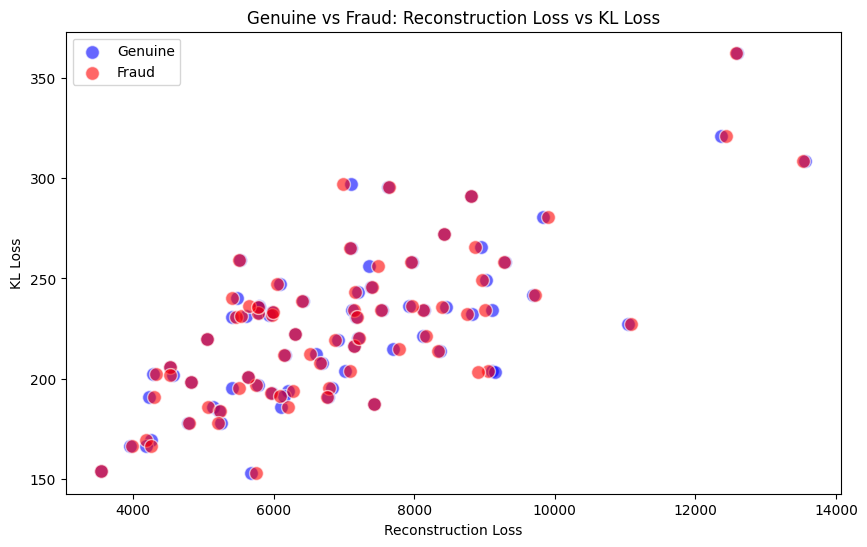

In [22]:
import matplotlib.pyplot as plt


min_length = min(len(genuine_reconstruction_loss), len(fraud_reconstruction_loss))
genuine_reconstruction_loss = genuine_reconstruction_loss[:min_length]
genuine_Kl_loss = genuine_Kl_loss[:min_length]
fraud_reconstruction_loss = fraud_reconstruction_loss[:min_length]
fraud_Kl_loss = fraud_Kl_loss[:min_length]

# Scatter plot for genuine and fraud data
plt.figure(figsize=(10, 6))

# Plot for genuine data (Reconstruction Loss vs KL Loss)
plt.scatter(genuine_reconstruction_loss, genuine_Kl_loss, label='Genuine', color='blue', alpha=0.6, edgecolors='w', s=100)

# Plot for fraud data (Reconstruction Loss vs KL Loss)
plt.scatter(fraud_reconstruction_loss, fraud_Kl_loss, label='Fraud', color='red', alpha=0.6, edgecolors='w', s=100)

# Add labels and title
plt.xlabel('Reconstruction Loss')
plt.ylabel('KL Loss')
plt.title('Genuine vs Fraud: Reconstruction Loss vs KL Loss')

# Add legend
plt.legend()

# Display the plot
plt.show()
